In [1]:
%matplotlib inline
# Importing standard Qiskit libraries and configuring account
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
# Loading your IBM Q account(s)
provider = IBMQ.load_account()

/opt/conda/lib/python3.7/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


In [2]:
import numpy as np
from qiskit import BasicAer
from qiskit.circuit import Parameter
from qiskit_textbook.tools import random_state, array_to_latex
from qiskit.aqua.components.optimizers import COBYLA
import matplotlib.pyplot as plt

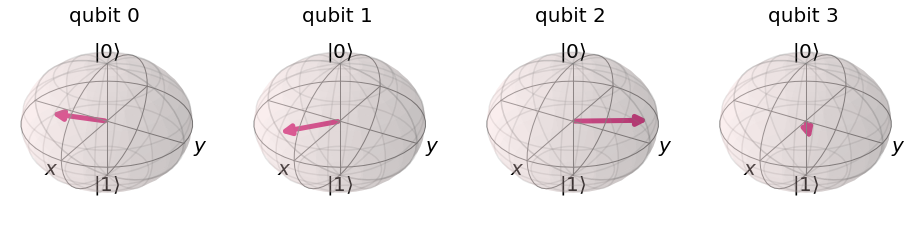

In [3]:
np.random.seed(123)
phi = random_state(4) # target
plot_bloch_multivector(phi*2) # *2 just to see things a bit better

In [4]:
class ParamQuantumCircuit:
    def __init__(self,n,L):
        self.blocks = 0
        self.layers = 0
        self.thetas = []
        self.circuit = QuantumCircuit(n)    
        for i in range(L):
            self.add_layer(n)

    # wrapper for drawing circuits
    def draw(self):
        return self.circuit.draw()
    
    # add 1 more layer to the main circuit
    def add_layer(self,n):
        i = self.blocks
        self.thetas += [Parameter(f'θ_{i+1},{j+1}') for j in range(n)] + \
                       [Parameter(f'θ_{i+2},{j+1}') for j in range(n)] # starts from 1
        # U_odd
        for j in range(n): # Rx gates
            self.circuit.rx(self.thetas[j-2*n], j)
        # U_even
        for j in range(n): # Rz gates
            self.circuit.rz(self.thetas[j-n], j)
        for j in range(n): # CZ gates
            for k in range(j+1,n):
                self.circuit.cz(j,k)
        # end of block
        self.circuit.barrier()
        self.blocks += 2
        self.layers += 1
    # run circuit
    def run(self, thetas):
        job = execute(self.circuit, 
                        BasicAer.get_backend('statevector_simulator'),
                        parameter_binds = [{bind : theta for bind,theta in zip(self.thetas,thetas)}])
        return job.result().get_statevector()

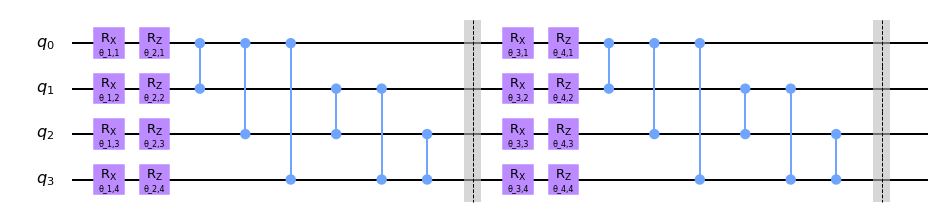

In [5]:
# example with 2 layers
qc = ParamQuantumCircuit(4,2)
qc.draw()

In [6]:
# ϵ = || |Ψ(θ)> − |φ> ||
def cost_func(thetas):
    psi = qc.run(thetas.tolist())
    return np.linalg.norm(psi-phi)

In [10]:
max_layers = 10
max_iters = [100,250,500,1000,2500,3500,5000]
sample_counts = [30,20,15, 5,   5,    5,    5] # just to show average trend
# preallocate results
# results = { max_iter: [ [] 
#                            for L in range(max_layers) ]  
#                                 for max_iter in max_iters }
epsilons = { max_iter: [ 0  for layer in range(max_layers) ] 
                            for max_iter in max_iters }
# optimize for various numbers of layers and iteration
for L in range(max_layers):
    # create circuit with L+1 layers
    qc = ParamQuantumCircuit(4,L+1)
    # for every circuit try out various iterations
    for max_iter,sample_count in zip(max_iters, sample_counts):
        # Initialize the COBYLA optimizer
        optimizer = COBYLA(maxiter=max_iter, tol=1e-4)
        # take more samples for showing overall average results
        for sample in range(sample_count):
            print(f'optimizing layer [{L+1}] with iteration [{max_iter}] sample [{sample+1}/{sample_count}]')
            # optimize from random parameters
            thetas = np.random.rand(len(qc.thetas)) * 2 * np.pi
            result = optimizer.optimize(len(thetas), cost_func, 
                                                              variable_bounds=[(0, 2 * np.pi)] * len(thetas), 
                                                              initial_point=thetas)
            epsilons[max_iter][L] += result[1]
        # average
        epsilons[max_iter][L] /= sample_count
            

optimizing layer [1] with iteration [100] sample [1/30]
optimizing layer [1] with iteration [100] sample [2/30]
optimizing layer [1] with iteration [100] sample [3/30]
optimizing layer [1] with iteration [100] sample [4/30]
optimizing layer [1] with iteration [100] sample [5/30]
optimizing layer [1] with iteration [100] sample [6/30]
optimizing layer [1] with iteration [100] sample [7/30]
optimizing layer [1] with iteration [100] sample [8/30]
optimizing layer [1] with iteration [100] sample [9/30]
optimizing layer [1] with iteration [100] sample [10/30]
optimizing layer [1] with iteration [100] sample [11/30]
optimizing layer [1] with iteration [100] sample [12/30]
optimizing layer [1] with iteration [100] sample [13/30]
optimizing layer [1] with iteration [100] sample [14/30]
optimizing layer [1] with iteration [100] sample [15/30]
optimizing layer [1] with iteration [100] sample [16/30]
optimizing layer [1] with iteration [100] sample [17/30]
optimizing layer [1] with iteration [100

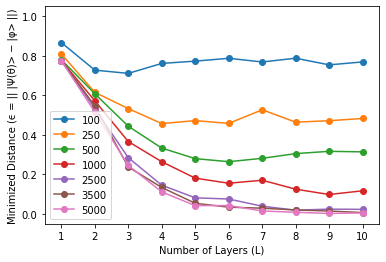

In [11]:
x = np.arange(max_layers) + 1
for max_iter in max_iters:
    y = np.array(epsilons[max_iter])
    plt.plot(x,y, marker='o', label=max_iter)

plt.ylim(-0.05,1.05)
plt.xlim(0.5,max_layers+0.5)
plt.xticks(x)
plt.legend(loc='lower left')
plt.xlabel('Number of Layers (L)')
plt.ylabel('Minimized Distance (ϵ = || |Ψ(θ)> − |φ> ||)')
plt.show()

In [15]:
# 6 layers seems good enough. Comparison with 5000 iteration
qc = ParamQuantumCircuit(4,6)
# optimize from random parameters
thetas = np.random.rand(len(qc.thetas)) * 2 * np.pi
result = COBYLA(maxiter=3500, tol=1e-4).optimize(len(thetas), cost_func, 
                                                  variable_bounds=[(0, 2 * np.pi)] * len(thetas), 
                                                  initial_point=thetas)
print(f'Error: {result[1]*100}%')
print(f'Parameters: {result[0]}')
psi = qc.run(result[0])

Error: 0.8144699128586688%
Parameters: [ 4.37217648  5.48012572  4.60231892  5.64928367  0.64252781  3.66225745
  1.47285971  3.70697221  5.95741961  1.43753137  6.74144137  6.19559652
 -0.01040421  2.65233409  3.76955369  1.82782718  1.62749458  6.15699765
  4.59894412  0.60289469  1.74684644  5.36904271  3.63472187  6.88126512
  0.1940274   4.11019317  4.39500115  4.29212799  3.7467245   3.63640277
  1.82585482  0.58147699  2.20050707  1.275086    4.29498194  2.52044257
  2.40916174  6.40480019  3.79007609  2.34552582  2.6356579   3.93596913
  5.86164765  1.91420503  3.91394106  0.90867697  3.70370503  1.06699614]


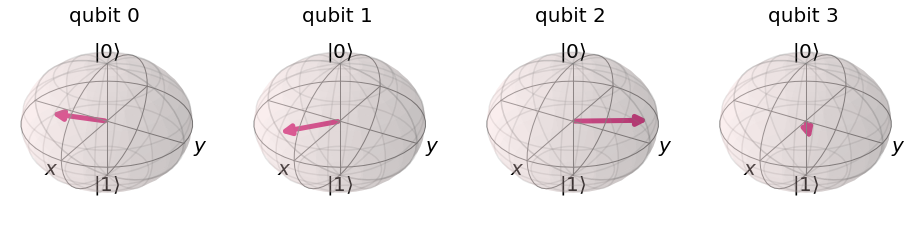

In [16]:
plot_bloch_multivector(phi*2) # target

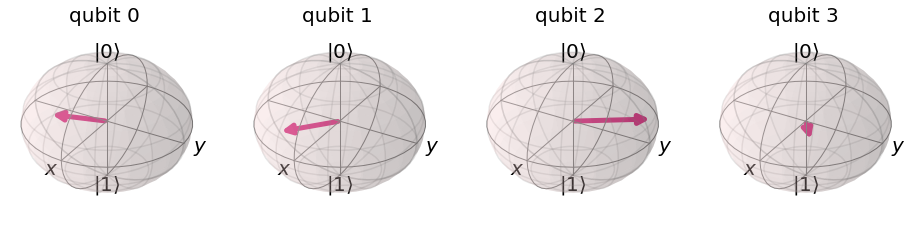

In [17]:
plot_bloch_multivector(psi*2) # predicted